1. Logging (no exogenous)
2. Weighting results by monthly average
3. A different model for winter months

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

import pickle

In [4]:
def mape(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Absolute Percentage Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
#     difference = abs((observations - estimates)/observations)
#     mape = (sum(difference)/len(observations))*100
    mape = np.mean(np.abs((observations - estimates) / observations)) * 100
    return mape

In [5]:
def mae(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Absolute Percentage Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
#     difference = abs((observations - estimates)/observations)
#     mape = (sum(difference)/len(observations))*100
    mae = np.mean(np.abs((observations - estimates)))
    return mae

In [6]:
def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

In [7]:
dataset = 'PGE-CSI-00114'

with open('pickles/data_'+dataset+'_train0.pickle', 'rb') as to_read:
    data_train = pickle.load(to_read)
with open('pickles/data_'+dataset+'_test0.pickle', 'rb') as to_read:
    data_test = pickle.load(to_read)

In [8]:
with open('pickles/weather_fresno.pickle', 'rb') as to_read:
    weather = pickle.load(to_read)
    
with open('pickles/solar_fresno.pickle', 'rb') as to_read:
    solar = pickle.load(to_read)

In [9]:
print(data_train.shape)
print(data_test.shape)

(43824,)
(8784,)


In [10]:
# combine data train and test
data_train = data_train.append(data_test)
data_train.shape

(52608,)

### 1. Logging - no exogenous variables

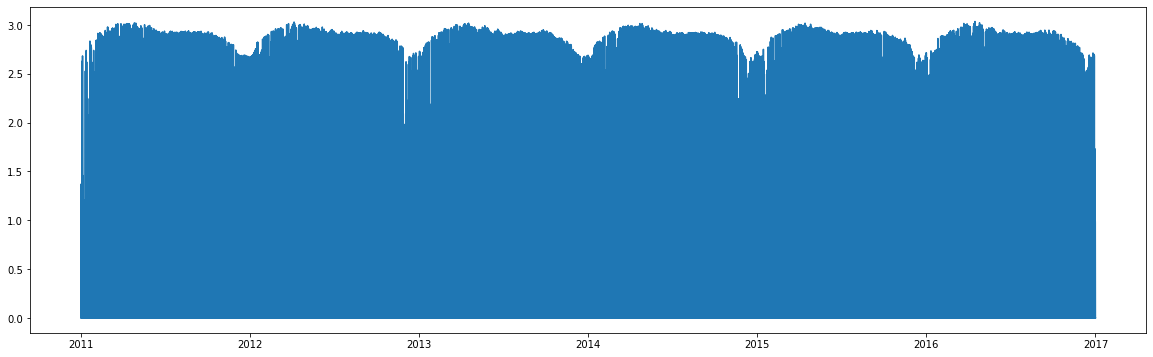

In [15]:
data_train_l = np.log(data_train+1)
plt.figure(figsize=(20,6))
plt.plot(data_train_l);

In [16]:
import statsmodels.api as sm

In [18]:
def forecast(startdate,x=7,ndays=30, data_train=data_train):
    train_mse = []
    test_mse = []
    train_rmse = []
    test_rmse = []
    train_mape = []
    test_mape = []
    train_mae = []
    test_mae = []
    data_for_all = []
    data_test1_all = []

    for i in range(0,ndays):
        # generate range
        train_start = startdate+dt.timedelta(hours=24*i)
        train_end = train_start+dt.timedelta(hours=(24*x-1))
        test_start = train_end+dt.timedelta(hours=1)
        test_end = test_start+dt.timedelta(hours=23)

        #subset data
        data_train1 = data_train[train_start:train_end]
        data_test1 = data_train[test_start:test_end]

        weather_train1 = weather[['sunlight']][train_start:train_end]
        weather_test1 = weather[['sunlight']][test_start:test_end]

        solar_train1 = solar[train_start:train_end]
        solar_test1 = solar[test_start:test_end]

    #     print(data_train1.shape)
    #     print(data_test1.shape)
    #     print(weather_train1.values.shape)
    #     print(weather_test1.values.shape)
    #     print(solar_train1.values.shape)
    #     print(solar_test1.values.shape)

        # model, predict, forecast
        sar = sm.tsa.statespace.SARIMAX(data_train1,
                                    order=(1,1,1), 
                                    seasonal_order=(0,1,1,24), 
                                    trend='c').fit(maxiter=250)

        y_pred = sar.predict(start=0,end=len(data_train1)-1,dynamic=False)

        a = data_test1.shape[0]
        data_for = sar.forecast(steps=a)

#         print(sar.mle_retvals)

        #remove non-0 data during night hours (can't have negative values, which appear to be momentum)
        for i,val in y_pred.iteritems():
            if weather_train1['sunlight'][i] == 0 :
                y_pred[i]=0
            if val < 0 :
                y_pred[i]=0
        for i,val in data_for.iteritems():
            if weather_test1['sunlight'][i] == 0 :
                data_for[i]=0
            if val < 0 :
                data_for[i]=0

        for j in data_for.values:
            data_for_all.append(j)
        for k in data_test1.values:
            data_test1_all.append(k)
        
#         train_mse.append(mse(data_train1.values,y_pred.values))
#         test_mse.append(mse(data_test1.values,data_for.values))
#         train_rmse.append(np.sqrt(mse(data_train1.values,y_pred.values)))
#         test_rmse.append(np.sqrt(mse(data_test1.values,data_for.values)))

        #calculate MAPE for non-zero values
#         for j,v in data_train1.iteritems():
#             if data_train1[j]==0:
#                 data_train1.pop(j)
#                 y_pred.pop(j)
#         for k,a in data_test1.iteritems():
#             if data_test1[k]==0:
#                 data_test1.pop(k)
#                 data_for.pop(k)

#         train_mape.append(mape(data_train1.values,y_pred.values))
#         test_mape.append(mape(data_test1.values,data_for.values))
        train_mae.append(mae(data_train1.values,y_pred.values))
        test_mae.append(mae(data_test1.values,data_for.values))

    #MAPE for test data
    plt.figure(figsize=(20,6))
    plt.plot(train_mae,alpha=0.5,label='train')
    plt.plot(test_mae,alpha=0.5,label='test')
    plt.title('MAE')
    plt.xlabel('days')
    plt.legend()
    plt.show();

    #RMSE for test data
    plt.figure(figsize=(20,6))
    plt.plot(train_rmse,alpha=0.5,label='train')
    plt.plot(test_rmse,alpha=0.5,label='test')
    plt.title('RSME')
    plt.xlabel('days')
    plt.legend()
    plt.show();
    
    #test data
    graph_index_a = pd.date_range(startdate,startdate+dt.timedelta(days=ndays+x),freq='H')[:-1]
    graph_index_f = pd.date_range(startdate+dt.timedelta(days=x),startdate+dt.timedelta(days=ndays+x),freq='H')[:-1]
    hist_data = data_train[startdate:startdate+dt.timedelta(days=ndays+x)][:-1]
    solar_data = solar[startdate:startdate+dt.timedelta(days=ndays+x)][:-1]
    weather_data = weather['sunlight'][startdate:startdate+dt.timedelta(days=ndays+x)][:-1]
    
    plt.figure(figsize=(20,6))
    plt.plot(graph_index_a,hist_data,alpha=0.5,label='actual')
    plt.plot(graph_index_f,data_for_all,alpha=0.5,label='forecasted')
    plt.title('forecasted vs. actual')
    plt.xlabel('days')
    plt.legend()
    plt.show();
    
    plt.figure(figsize=(20,6))
    plt.plot(graph_index_a,solar_data['DHI'],alpha=0.5,label='DHI')
    plt.plot(graph_index_a,solar_data['DNI'],alpha=0.5,label='DNI')
    plt.plot(graph_index_a,solar_data['GHI'],alpha=0.5,label='GHI')
    plt.title('solar irradiance')
    plt.xlabel('days')
    plt.legend()
    plt.show();
    
    #save out data
    historical = hist_data.to_frame()
    forecast = pd.DataFrame(data_for_all, index=graph_index_f, columns=['forecast'])
    solar_i = pd.DataFrame(solar_data, index=graph_index_a)
    sunlight = weather_data.to_frame()

    all_data = pd.merge(historical,forecast,left_index=True,right_index=True,how='left')
    all_data = pd.merge(all_data,solar_i,left_index=True,right_index=True)
    all_data = pd.merge(all_data,sunlight,left_index=True,right_index=True)
    
    #save out forecast performance
    forecast_perf = pd.DataFrame(test_mae, index= sorted(list(set(graph_index_f.date))), columns=['MAE'])
    # # log MAPE and rolling average
    # forecast_mape['MAPE2'] = np.log(forecast_mape['MAPE'])
    # forecast_mape['MAPE2_30d'] = forecast_mape['MAPE2'].rolling(30,center=True).mean()
    
    return all_data, forecast_perf

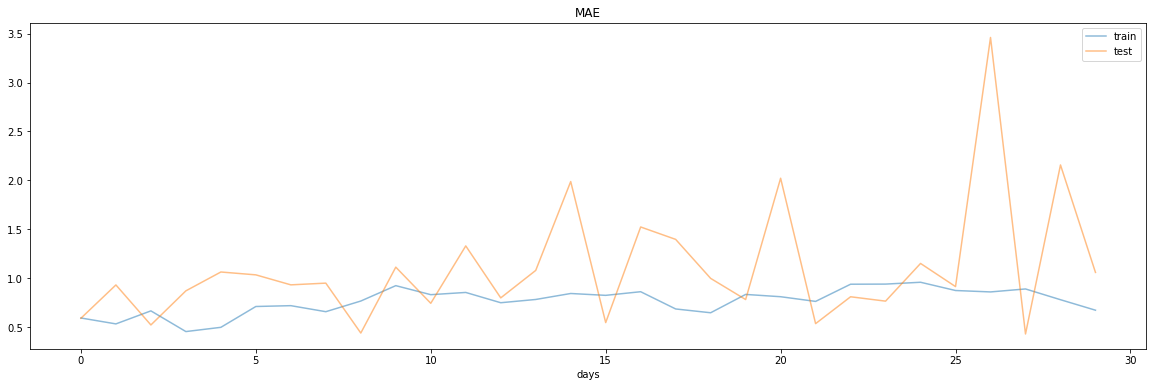

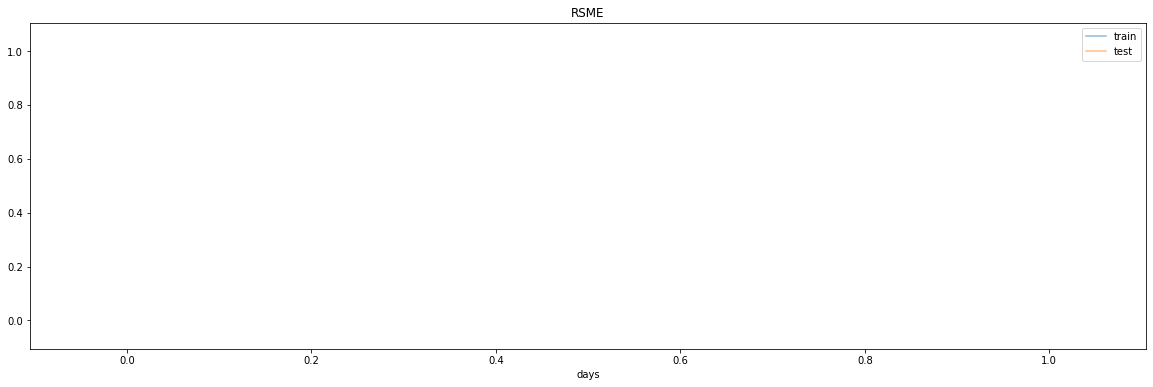

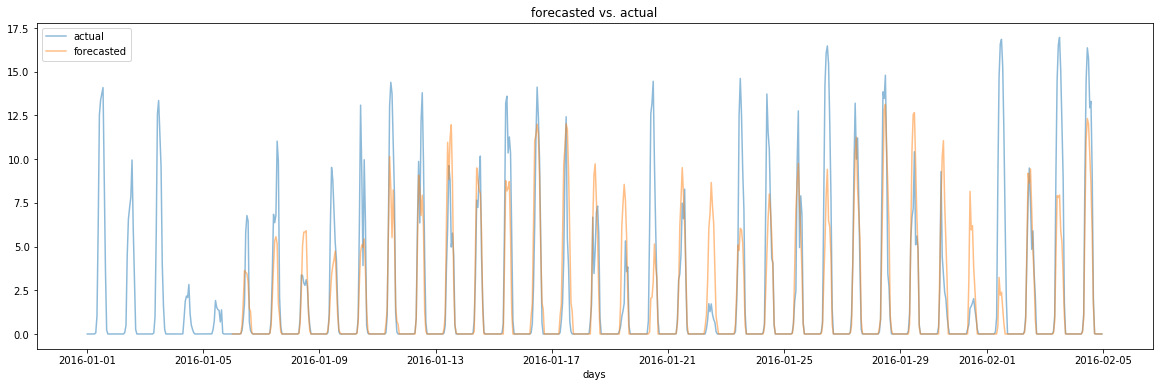

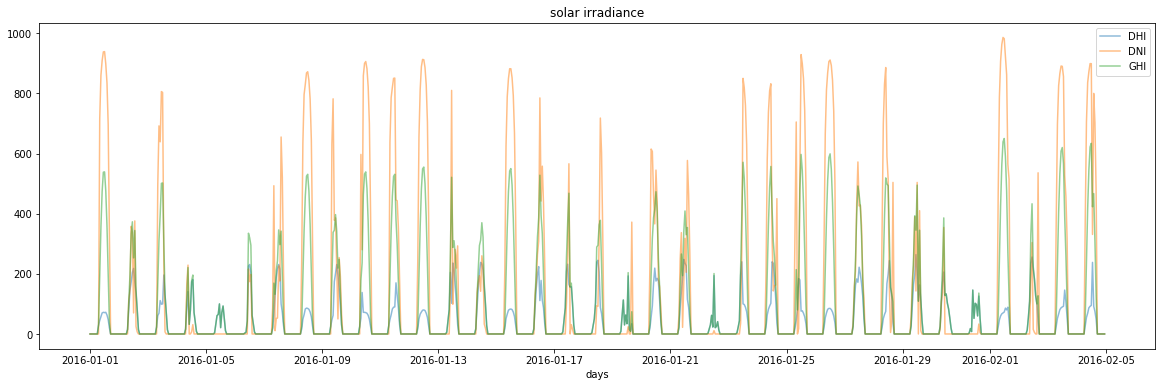

In [21]:
#forecast with non-logged data, no exog
all_data, forecast_perf = forecast(dt.datetime(2016,1,1,0,0),x=5,ndays=30, data_train = data_train)


/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


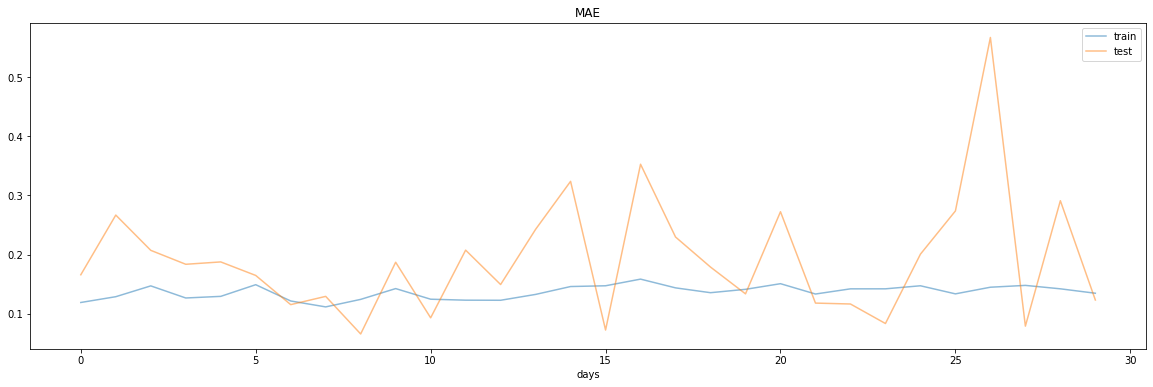

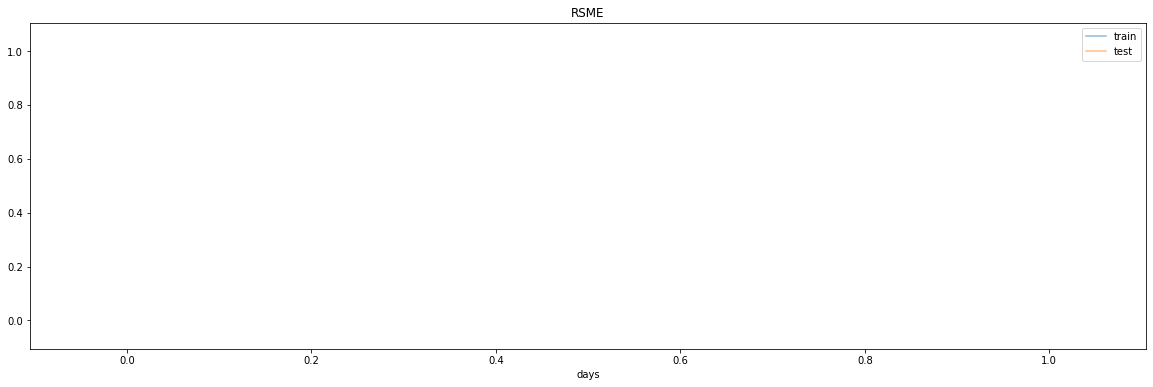

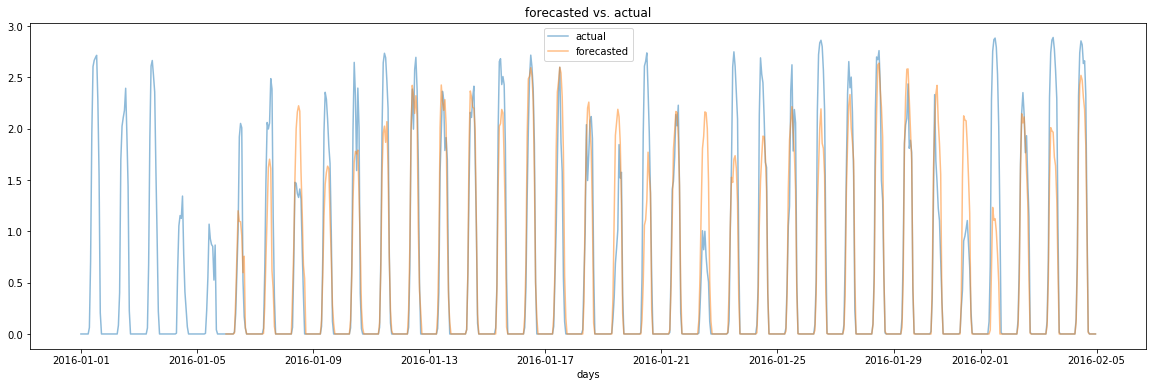

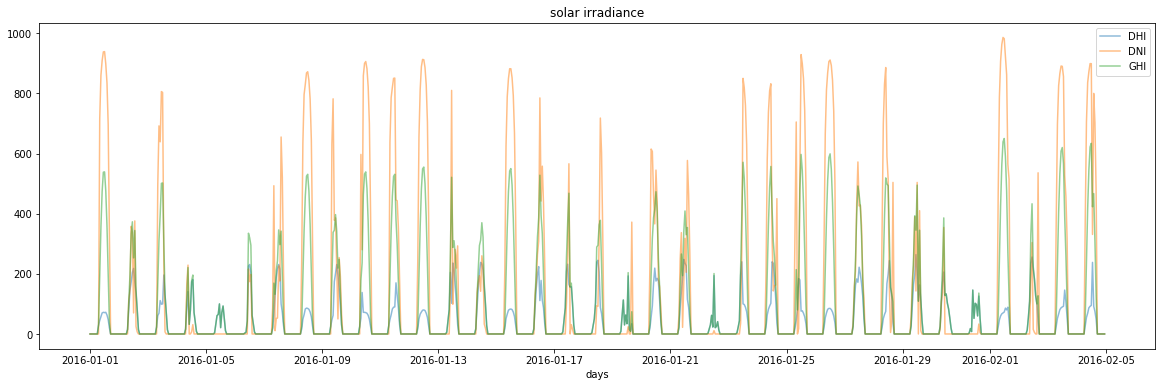

In [20]:
#forecast with logged data, no exog
all_data_1, forecast_perf_1 = forecast(dt.datetime(2016,1,1,0,0),x=5,ndays=30, data_train = data_train_l)


### Compare logged to not logged

In [38]:
import math

all_data_1['kWh2'] = [math.exp(x)-1 for x in all_data_1['kWh']]
all_data_1['forecast2'] = [math.exp(x)-1 for x in all_data_1['forecast']]

forecast_perf_1['MAE2'] = [math.exp(x)-1 for x in forecast_perf_1['MAE']]

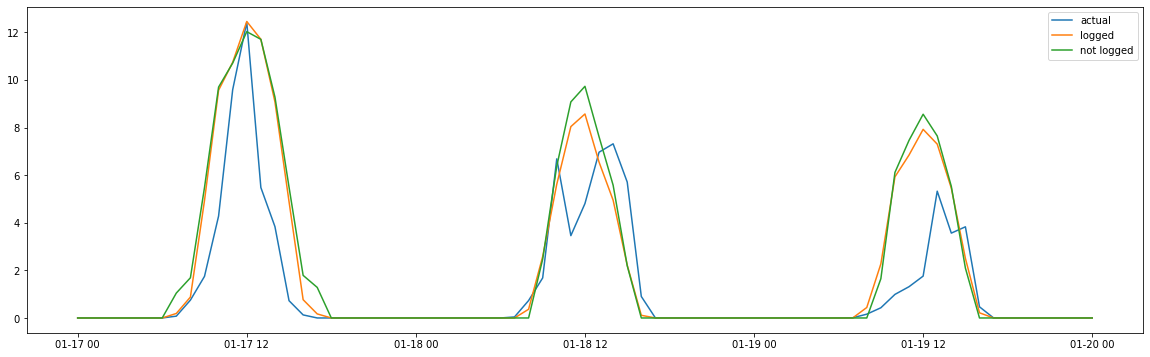

In [47]:
start=dt.datetime(2016,1,17,0,0)
end=start+dt.timedelta(days=3)
plt.figure(figsize=(20,6))
plt.plot(all_data_1['kWh2'][start:end],label='actual')
plt.plot(all_data_1['forecast2'][start:end],label='logged')
plt.plot(all_data['forecast'][start:end],label='not logged')
plt.legend();

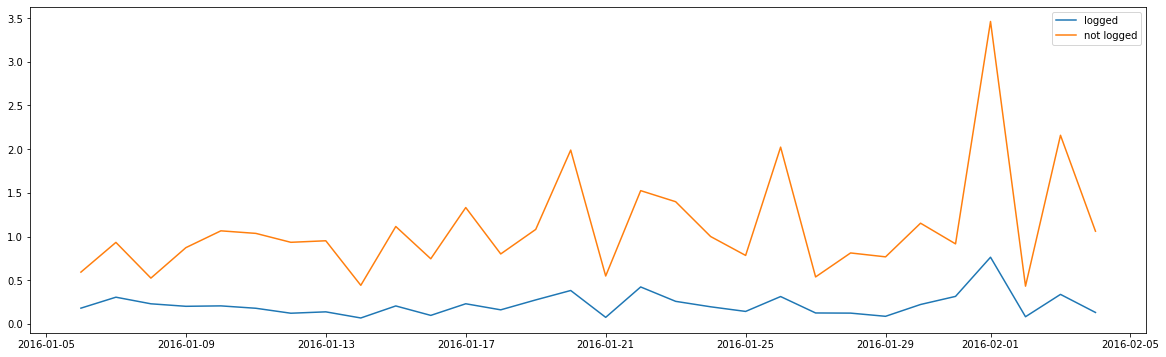

In [41]:
plt.figure(figsize=(20,6))
plt.plot(forecast_perf_1['MAE2'],label='logged')
plt.plot(forecast_perf['MAE'],label='not logged')
plt.legend();

In [42]:
forecast_perf_1

,MAE,MAE2
2016-01-06,0.165823,0.180364
2016-01-07,0.266740,0.305701
2016-01-08,0.207126,0.230137
2016-01-09,0.183556,0.201482
2016-01-10,0.187548,0.206288
2016-01-11,0.164684,0.179020
2016-01-12,0.115338,0.122253
2016-01-13,0.129295,0.138026
2016-01-14,0.065733,0.067941
2016-01-15,0.187011,0.205640


logged works well without exogenous variables!

### 2. Logging w/ exogenous variables

In [48]:
def forecast_w_exog(startdate,x=7,ndays=30, data_train=data_train):
    train_mse = []
    test_mse = []
    train_rmse = []
    test_rmse = []
    train_mape = []
    test_mape = []
    train_mae = []
    test_mae = []
    data_for_all = []
    data_test1_all = []

    for i in range(0,ndays):
        # generate range
        train_start = startdate+dt.timedelta(hours=24*i)
        train_end = train_start+dt.timedelta(hours=(24*x-1))
        test_start = train_end+dt.timedelta(hours=1)
        test_end = test_start+dt.timedelta(hours=23)

        #subset data
        data_train1 = data_train[train_start:train_end]
        data_test1 = data_train[test_start:test_end]

        weather_train1 = weather[['sunlight']][train_start:train_end]
        weather_test1 = weather[['sunlight']][test_start:test_end]

        solar_train1 = solar[train_start:train_end]
        solar_test1 = solar[test_start:test_end]

    #     print(data_train1.shape)
    #     print(data_test1.shape)
    #     print(weather_train1.values.shape)
    #     print(weather_test1.values.shape)
    #     print(solar_train1.values.shape)
    #     print(solar_test1.values.shape)

        # model, predict, forecast
        sar = sm.tsa.statespace.SARIMAX(data_train1,
                                    exog=solar_train1.values,
                                    order=(1,1,1), 
                                    seasonal_order=(0,1,1,24), 
                                    trend='c').fit(maxiter=250)

        y_pred = sar.predict(start=0,end=len(data_train1)-1,dynamic=False)

        a = data_test1.shape[0]
        data_for = sar.forecast(steps=a, exog=solar_test1.values)

#         print(sar.mle_retvals)

        #remove non-0 data during night hours (can't have negative values, which appear to be momentum)
        for i,val in y_pred.iteritems():
            if weather_train1['sunlight'][i] == 0 :
                y_pred[i]=0
            if val < 0 :
                y_pred[i]=0
        for i,val in data_for.iteritems():
            if weather_test1['sunlight'][i] == 0 :
                data_for[i]=0
            if val < 0 :
                data_for[i]=0

        for j in data_for.values:
            data_for_all.append(j)
        for k in data_test1.values:
            data_test1_all.append(k)
        
#         train_mse.append(mse(data_train1.values,y_pred.values))
#         test_mse.append(mse(data_test1.values,data_for.values))
#         train_rmse.append(np.sqrt(mse(data_train1.values,y_pred.values)))
#         test_rmse.append(np.sqrt(mse(data_test1.values,data_for.values)))

        #calculate MAPE for non-zero values
#         for j,v in data_train1.iteritems():
#             if data_train1[j]==0:
#                 data_train1.pop(j)
#                 y_pred.pop(j)
#         for k,a in data_test1.iteritems():
#             if data_test1[k]==0:
#                 data_test1.pop(k)
#                 data_for.pop(k)

#         train_mape.append(mape(data_train1.values,y_pred.values))
#         test_mape.append(mape(data_test1.values,data_for.values))
        train_mae.append(mae(data_train1.values,y_pred.values))
        test_mae.append(mae(data_test1.values,data_for.values))

    #MAPE for test data
    plt.figure(figsize=(20,6))
    plt.plot(train_mae,alpha=0.5,label='train')
    plt.plot(test_mae,alpha=0.5,label='test')
    plt.title('MAE')
    plt.xlabel('days')
    plt.legend()
    plt.show();

    #RMSE for test data
    plt.figure(figsize=(20,6))
    plt.plot(train_rmse,alpha=0.5,label='train')
    plt.plot(test_rmse,alpha=0.5,label='test')
    plt.title('RSME')
    plt.xlabel('days')
    plt.legend()
    plt.show();
    
    #test data
    graph_index_a = pd.date_range(startdate,startdate+dt.timedelta(days=ndays+x),freq='H')[:-1]
    graph_index_f = pd.date_range(startdate+dt.timedelta(days=x),startdate+dt.timedelta(days=ndays+x),freq='H')[:-1]
    hist_data = data_train[startdate:startdate+dt.timedelta(days=ndays+x)][:-1]
    solar_data = solar[startdate:startdate+dt.timedelta(days=ndays+x)][:-1]
    weather_data = weather['sunlight'][startdate:startdate+dt.timedelta(days=ndays+x)][:-1]
    
    plt.figure(figsize=(20,6))
    plt.plot(graph_index_a,hist_data,alpha=0.5,label='actual')
    plt.plot(graph_index_f,data_for_all,alpha=0.5,label='forecasted')
    plt.title('forecasted vs. actual')
    plt.xlabel('days')
    plt.legend()
    plt.show();
    
    plt.figure(figsize=(20,6))
    plt.plot(graph_index_a,solar_data['DHI'],alpha=0.5,label='DHI')
    plt.plot(graph_index_a,solar_data['DNI'],alpha=0.5,label='DNI')
    plt.plot(graph_index_a,solar_data['GHI'],alpha=0.5,label='GHI')
    plt.title('solar irradiance')
    plt.xlabel('days')
    plt.legend()
    plt.show();
    
    #save out data
    historical = hist_data.to_frame()
    forecast = pd.DataFrame(data_for_all, index=graph_index_f, columns=['forecast'])
    solar_i = pd.DataFrame(solar_data, index=graph_index_a)
    sunlight = weather_data.to_frame()

    all_data = pd.merge(historical,forecast,left_index=True,right_index=True,how='left')
    all_data = pd.merge(all_data,solar_i,left_index=True,right_index=True)
    all_data = pd.merge(all_data,sunlight,left_index=True,right_index=True)
    
    #save out forecast performance
    forecast_perf = pd.DataFrame(test_mae, index= sorted(list(set(graph_index_f.date))), columns=['MAE'])
    # # log MAPE and rolling average
    # forecast_mape['MAPE2'] = np.log(forecast_mape['MAPE'])
    # forecast_mape['MAPE2_30d'] = forecast_mape['MAPE2'].rolling(30,center=True).mean()
    
    return all_data, forecast_perf

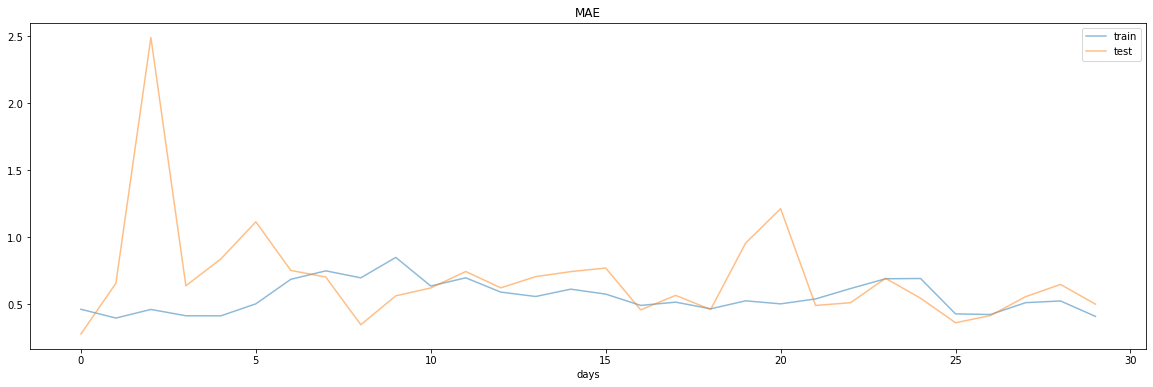

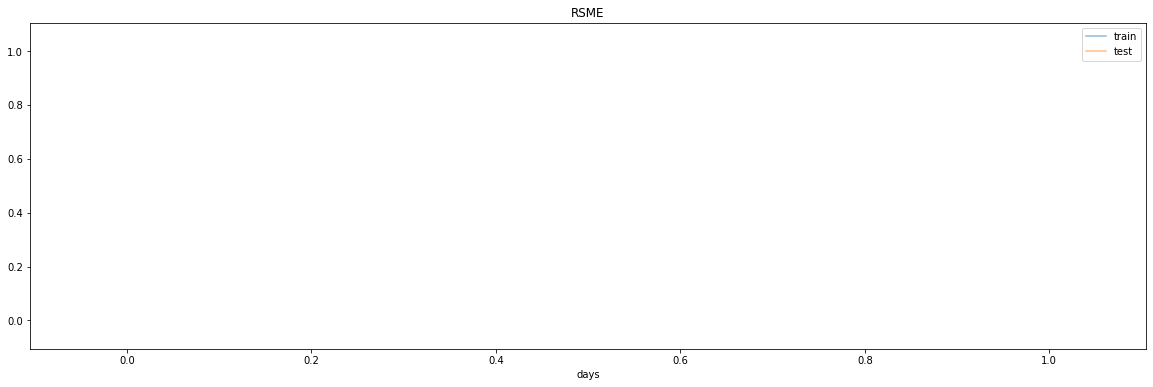

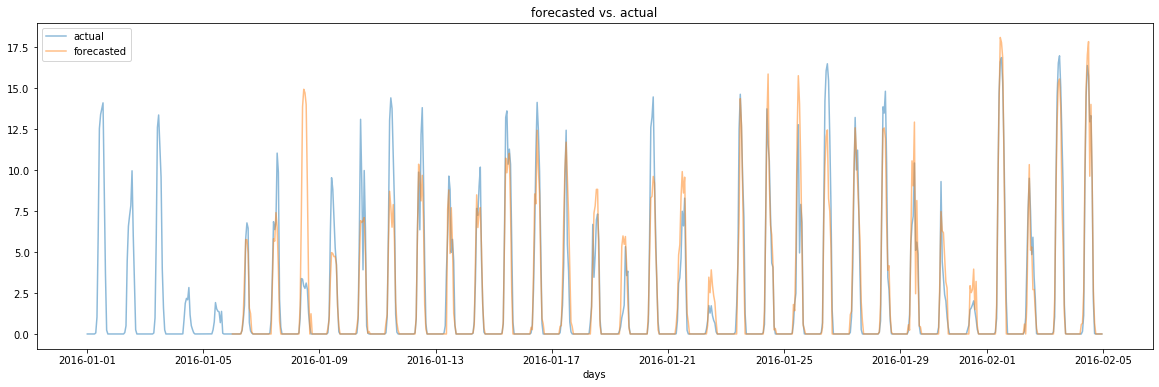

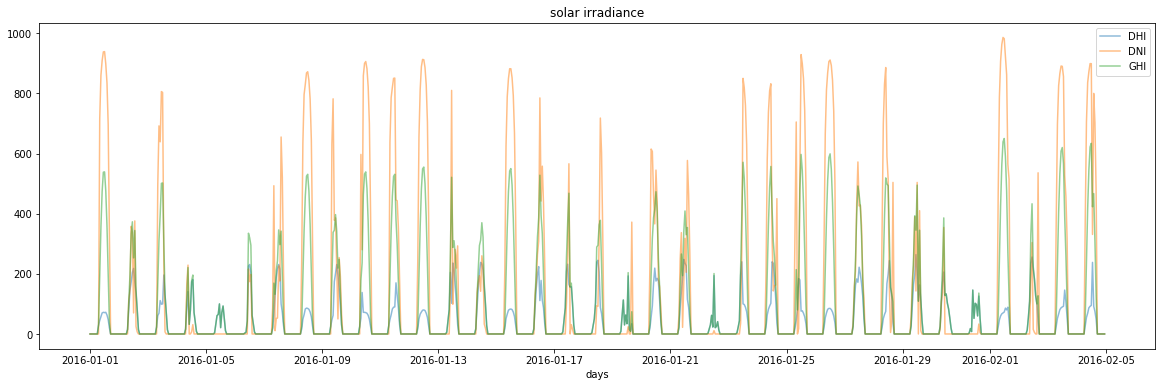

In [49]:
#forecast with non-logged data, with exog
all_data_2, forecast_perf_2 = forecast_w_exog(dt.datetime(2016,1,1,0,0),x=5,ndays=30, data_train = data_train)


/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


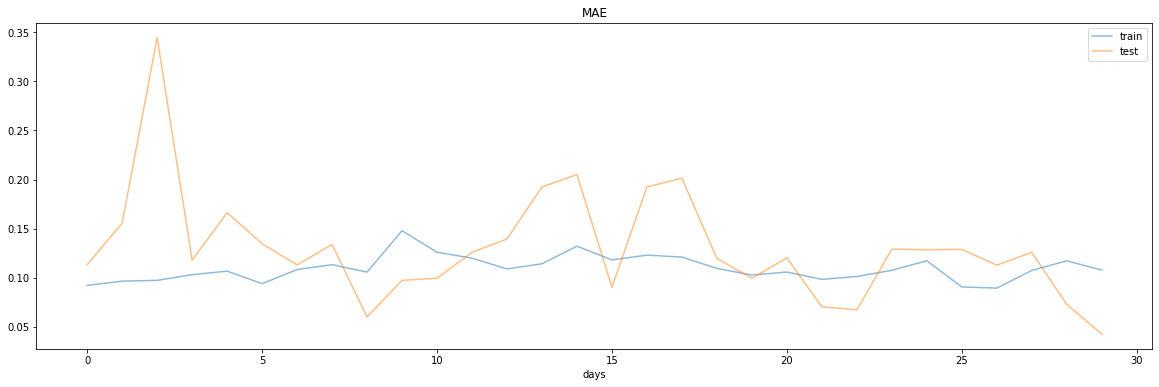

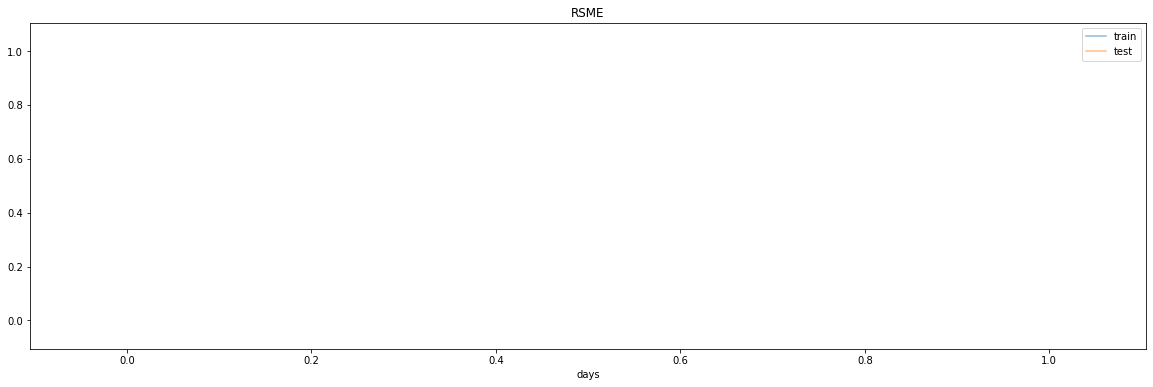

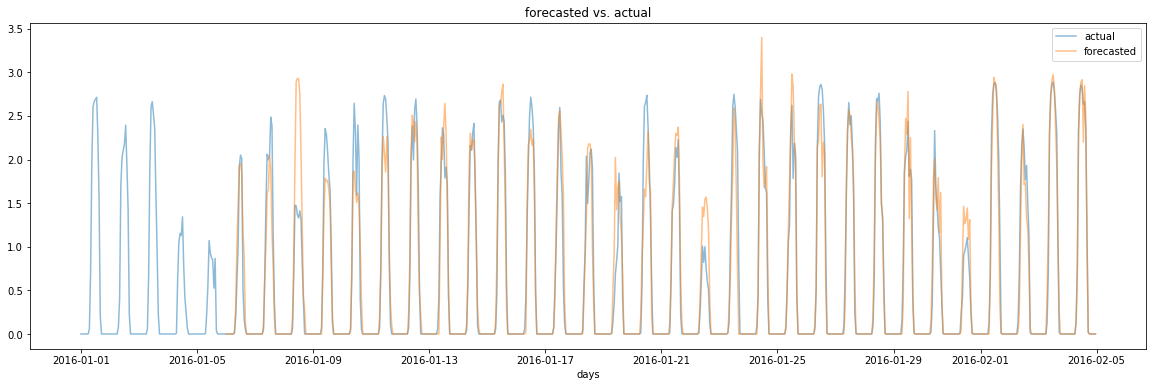

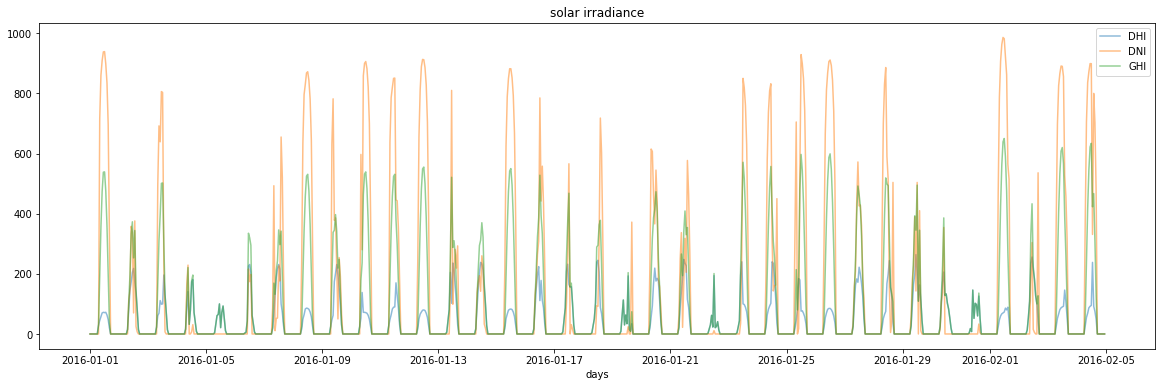

In [50]:
#forecast with logged data, with exog
all_data_3, forecast_perf_3 = forecast_w_exog(dt.datetime(2016,1,1,0,0),x=5,ndays=30, data_train = data_train_l)


### Compare logged to not logged

In [51]:
import math

all_data_3['kWh2'] = [math.exp(x)-1 for x in all_data_3['kWh']]
all_data_3['forecast2'] = [math.exp(x)-1 for x in all_data_3['forecast']]

forecast_perf_3['MAE2'] = [math.exp(x)-1 for x in forecast_perf_3['MAE']]

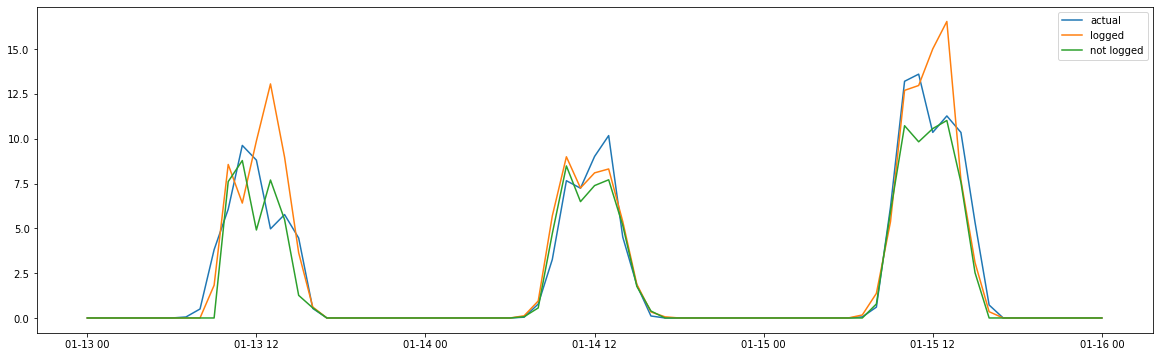

In [60]:
start=dt.datetime(2016,1,13,0,0)
end=start+dt.timedelta(days=3)
plt.figure(figsize=(20,6))
plt.plot(all_data_2['kWh'][start:end],label='actual')
plt.plot(all_data_3['forecast2'][start:end],label='logged')
plt.plot(all_data_2['forecast'][start:end],label='not logged')
plt.legend();

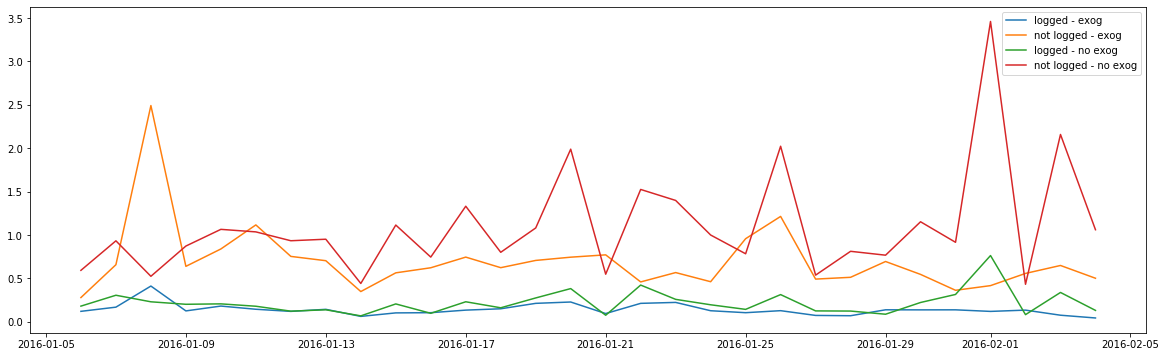

In [61]:
plt.figure(figsize=(20,6))
plt.plot(forecast_perf_3['MAE2'],label='logged - exog')
plt.plot(forecast_perf_2['MAE'],label='not logged - exog')
plt.plot(forecast_perf_1['MAE2'],label='logged - no exog')
plt.plot(forecast_perf['MAE'],label='not logged - no exog')
plt.legend();

### 1a. Generate data for presentation (one year prior to presentation day)

/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.p

/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.p

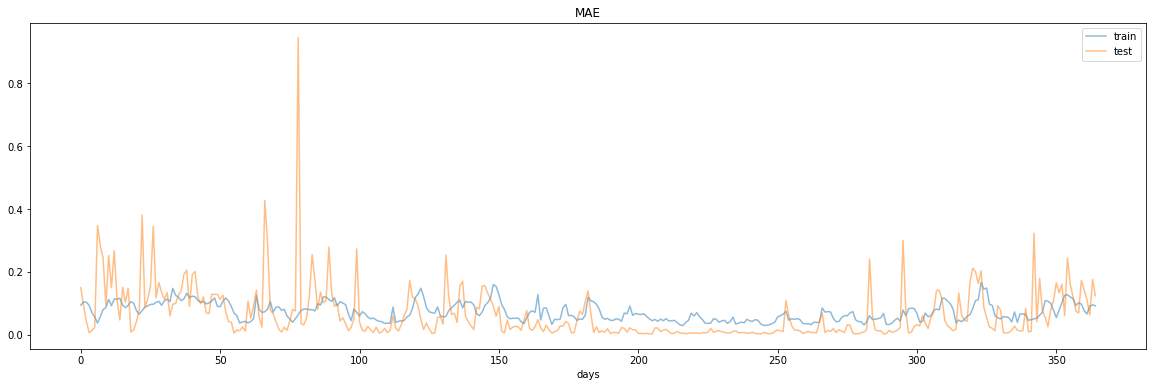

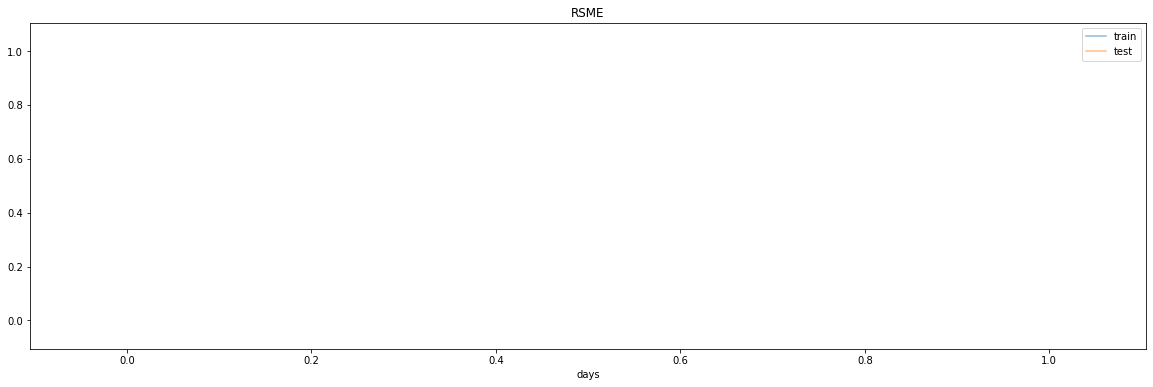

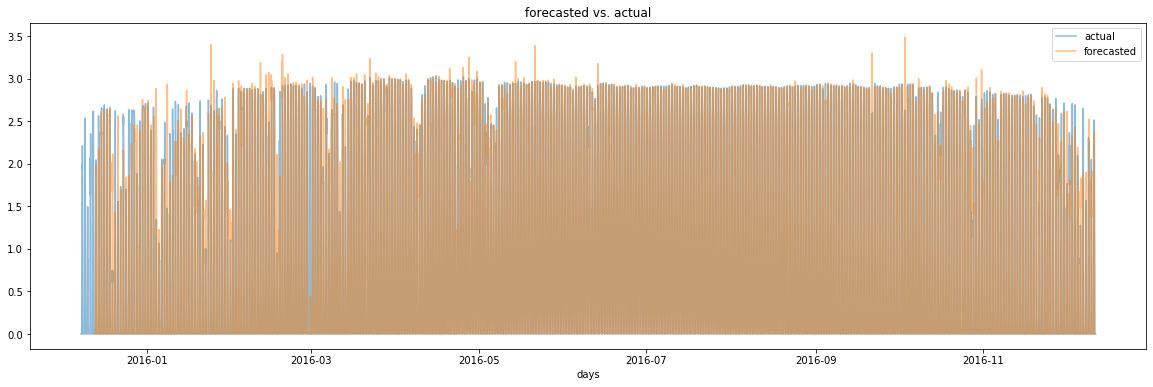

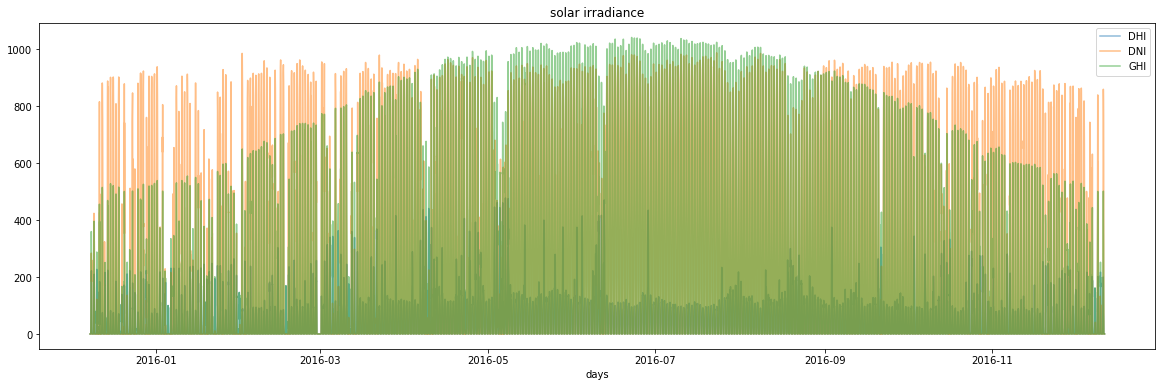

In [104]:
#forecast with logged data, with exog
all_data_4, forecast_perf_4 = forecast_w_exog(dt.datetime(2015,12,8,0,0),x=5,ndays=365, data_train = data_train_l)


In [105]:
import math

all_data_4['kWh2'] = [math.exp(x)-1 for x in all_data_4['kWh']]
all_data_4['forecast2'] = [math.exp(x)-1 for x in all_data_4['forecast']]

forecast_perf_4['MAE2'] = [math.exp(x)-1 for x in forecast_perf_4['MAE']]

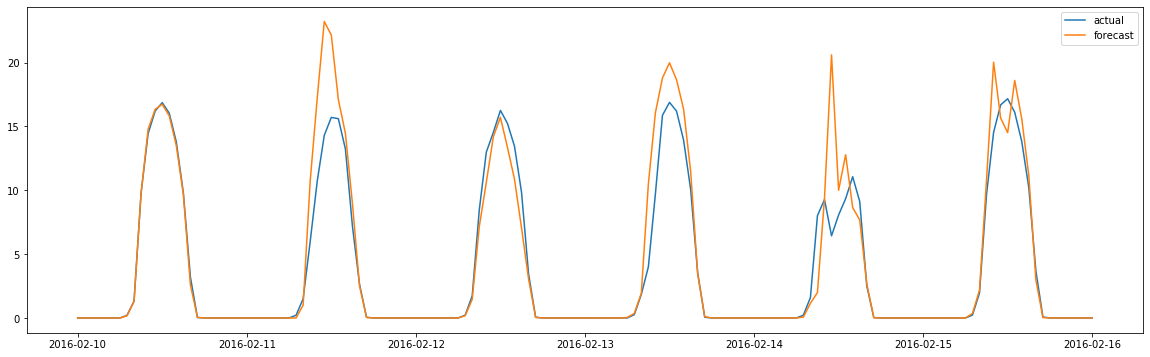

In [106]:
start=dt.datetime(2016,2,10,0,0)
end=start+dt.timedelta(days=6)
plt.figure(figsize=(20,6))
plt.plot(all_data_4['kWh2'][start:end],label='actual')
plt.plot(all_data_4['forecast2'][start:end],label='forecast')
plt.legend();

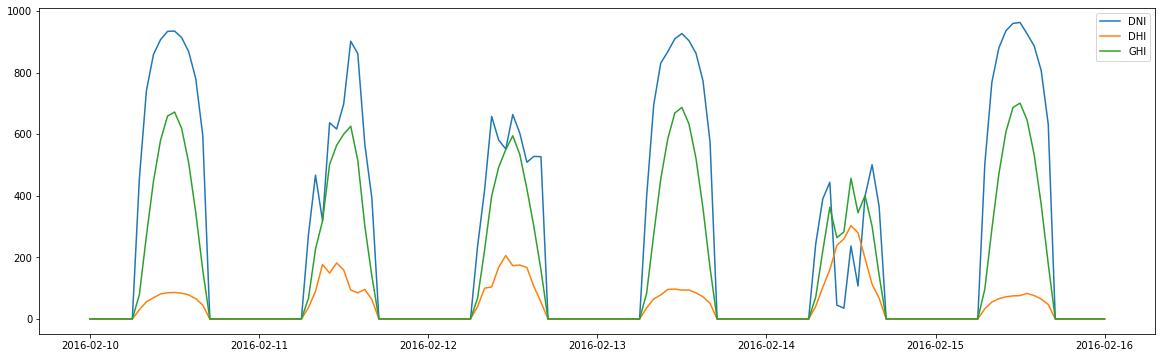

In [107]:
# start=dt.datetime(2016,2,28,0,0)
# end=start+dt.timedelta(days=3)
plt.figure(figsize=(20,6))
plt.plot(all_data_4['DNI'][start:end],label='DNI')
plt.plot(all_data_4['DHI'][start:end],label='DHI')
plt.plot(all_data_4['GHI'][start:end],label='GHI')
plt.legend();

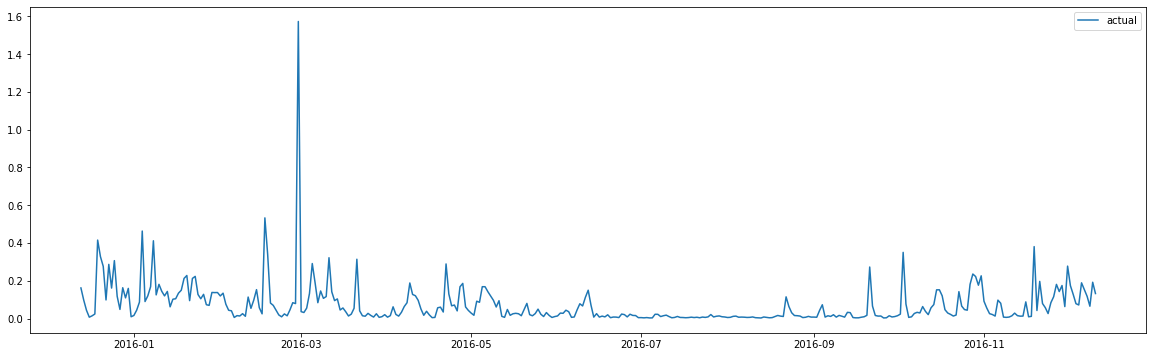

In [108]:
# start=dt.date(2015,1,13)
# end=start+dt.timedelta(days=300)
plt.figure(figsize=(20,6))
plt.plot(forecast_perf_4['MAE2'],label='actual')
# plt.plot(all_data_4['forecast2'][start:end],label='forecast')
plt.legend();

#### Alternative MAE calculation (exclude nighttime hours)

In [328]:
new_ae = all_data_4[['kWh2','forecast2']][(all_data_4['kWh2']!=0) & (np.isnan(all_data_4['forecast2'])==False)]

In [329]:
new_ae['AE'] = new_ae['kWh2']-new_ae['forecast2']
new_ae['absAE'] = abs(new_ae['AE'])

In [338]:
new_mae = new_ae.groupby(new_ae.index.date)['absAE'].mean()

#suppress new year
new_mae[dt.date(2016,2,29)] = 0

new_mae = pd.DataFrame(new_mae)
#calculate rolling average
new_mae['MAE2_30D_mean'] = new_mae.rolling(30,center=True).mean()
new_mae.rename(columns={"absAE": "Mae2"}, inplace=True)

In [339]:
new_mae['MAE2_30D_mean'].describe()

count    336.000000
mean       0.866999
std        0.532586
min        0.084017
25%        0.364951
50%        0.954033
75%        1.215846
max        1.999452
Name: MAE2_30D_mean, dtype: float64

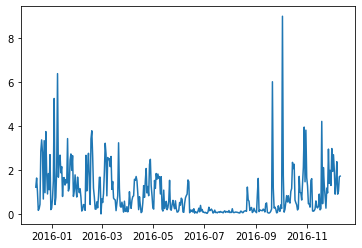

In [307]:
plt.plot(new_mae);

#### Save out data

In [333]:
#exclude actual for latest data
latest = max(all_data_4.index.date)
all_data_4['kWh2'][all_data_4.index.date == latest] = np.nan

/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [272]:
# forecast_perf_4['MAE2_30D_mean'] = forecast_perf_4['MAE2'].rolling(30,center=True).mean()

count    336.000000
mean       0.066751
std        0.046679
min        0.007579
25%        0.025859
50%        0.059030
75%        0.089348
max        0.166711
Name: MAE2_30D_mean, dtype: float64

In [340]:
all_data_4.to_csv('output/all_data.csv')
new_mae.to_csv('output/forecast_perf.csv')

### 2. Try accounting for annual seasonality by weighting data with monthly average differences

In [59]:
dt.datetime(2016,12,11)-dt.timedelta(days=365+5)

datetime.datetime(2015, 12, 7, 0, 0)

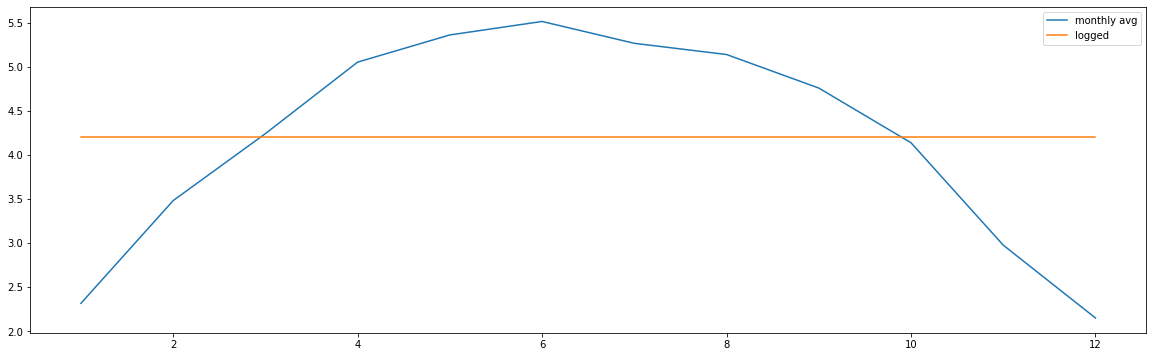

In [70]:
# Calculate monthly differences
avg_by_month = data_train.groupby(data_train.index.month).mean()
tot_avg = np.mean(data_train)

plt.figure(figsize=(20,6))
plt.plot(avg_by_month.index,avg_by_month,label='monthly avg')
plt.plot(avg_by_month.index,[tot_avg]*12,label='logged')
plt.legend();

In [98]:
# Create variable to adjust each month's data
monthly_var = pd.DataFrame(1-(avg_by_month - tot_avg)/tot_avg)
monthly_var

,kWh
date_time,
1,1.449259
2,1.171410
3,0.990284
4,0.796863
5,0.723369
6,0.686936
7,0.746032
8,0.776329
9,0.867009


In [109]:
all_data_4['join_var'] = all_data_4.index.month
all_data_4

,kWh,forecast,DHI,DNI,GHI,sunlight,kWh2,forecast2,join_var
date_time,,,,,,,,,
2015-12-08 00:00:00,0.0,NaN,0,0,0,0,0.0,NaN,12
2015-12-08 01:00:00,0.0,NaN,0,0,0,0,0.0,NaN,12
2015-12-08 02:00:00,0.0,NaN,0,0,0,0,0.0,NaN,12
2015-12-08 03:00:00,0.0,NaN,0,0,0,0,0.0,NaN,12
2015-12-08 04:00:00,0.0,NaN,0,0,0,0,0.0,NaN,12
...,...,...,...,...,...,...,...,...,...
2016-12-11 19:00:00,0.0,0.0,0,0,0,0,0.0,0.0,12
2016-12-11 20:00:00,0.0,0.0,0,0,0,0,0.0,0.0,12
2016-12-11 21:00:00,0.0,0.0,0,0,0,0,0.0,0.0,12


In [155]:
all_data_4a = pd.merge(all_data_4,monthly_var,left_on='join_var',right_on='date_time')
all_data_4a.index = all_data_4.index
all_data_4a['forecast3'] = all_data_4a['forecast2']*(all_data_4a['kWh_y']*0.7)
all_data_4a

,kWh_x,forecast,DHI,DNI,GHI,sunlight,kWh2,forecast2,join_var,kWh_y,kWh_adj,forecast3
date_time,,,,,,,,,,,,
2015-12-08 00:00:00,0.0,NaN,0,0,0,0,0.0,NaN,12,1.488857,1.339971,NaN
2015-12-08 01:00:00,0.0,NaN,0,0,0,0,0.0,NaN,12,1.488857,1.339971,NaN
2015-12-08 02:00:00,0.0,NaN,0,0,0,0,0.0,NaN,12,1.488857,1.339971,NaN
2015-12-08 03:00:00,0.0,NaN,0,0,0,0,0.0,NaN,12,1.488857,1.339971,NaN
2015-12-08 04:00:00,0.0,NaN,0,0,0,0,0.0,NaN,12,1.488857,1.339971,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-11 19:00:00,0.0,0.0,0,0,0,0,0.0,0.0,11,1.291882,1.162694,0.0
2016-12-11 20:00:00,0.0,0.0,0,0,0,0,0.0,0.0,11,1.291882,1.162694,0.0
2016-12-11 21:00:00,0.0,0.0,0,0,0,0,0.0,0.0,11,1.291882,1.162694,0.0


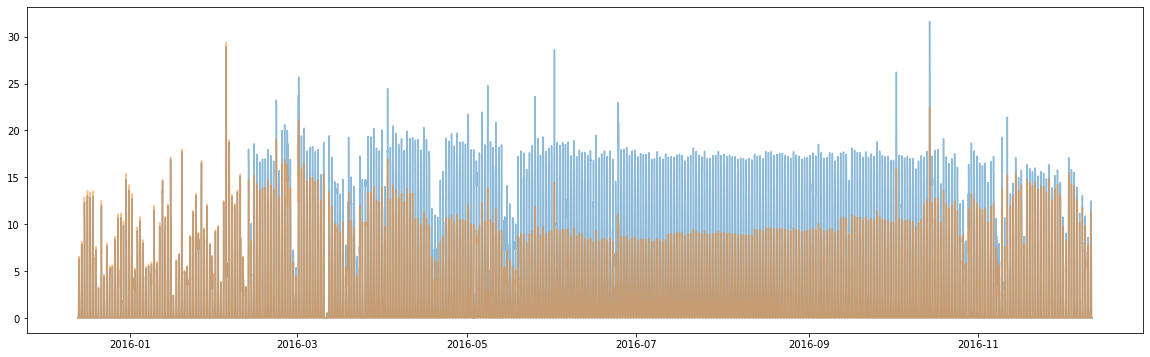

In [156]:
plt.figure(figsize=(20,6))
# plt.plot(all_data_4a['kWh2'],alpha=0.5)
plt.plot(all_data_4a['forecast2'],alpha=0.5)
plt.plot(all_data_4a['forecast3'],alpha=0.5);

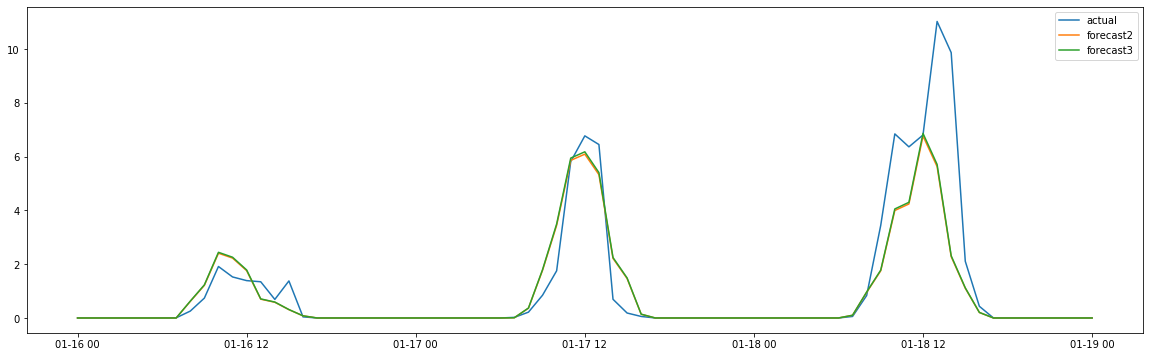

In [157]:
start=dt.datetime(2016,1,16,0,0)
end=start+dt.timedelta(days=3)
plt.figure(figsize=(20,6))
plt.plot(all_data_4a['kWh2'][start:end],label='actual')
plt.plot(all_data_4a['forecast2'][start:end],label='forecast2')
plt.plot(all_data_4a['forecast3'][start:end],label='forecast3')
plt.legend();

In [158]:
all_data_4a['AE2'] = abs(all_data_4a['kWh2']-all_data_4a['forecast2'])
all_data_4a['AE3'] = abs(all_data_4a['kWh2']-all_data_4a['forecast3'])

In [159]:
print(np.mean(all_data_4a['AE2'][all_data_4a.index.date <= dt.date(2016,3,1)]))
print(np.mean(all_data_4a['AE3'][all_data_4a.index.date <= dt.date(2016,3,1)]))

0.7448190163497582
0.7944578062753984


In [136]:
monthly_var['kWh_adj'] = monthly_var['kWh']*0.90
monthly_var

,kWh,kWh_adj
date_time,,
1,1.449259,1.304333
2,1.171410,1.054269
3,0.990284,0.891256
4,0.796863,0.717177
5,0.723369,0.651032
6,0.686936,0.618243
7,0.746032,0.671428
8,0.776329,0.698697
9,0.867009,0.780308


In [160]:
all_data_4[-1:]

,kWh,forecast,DHI,DNI,GHI,sunlight,kWh2,forecast2,join_var
date_time,,,,,,,,,
2016-12-11 23:00:00,0.0,0.0,0,0,0,0,0.0,0.0,12


### 3. A different model for winter months

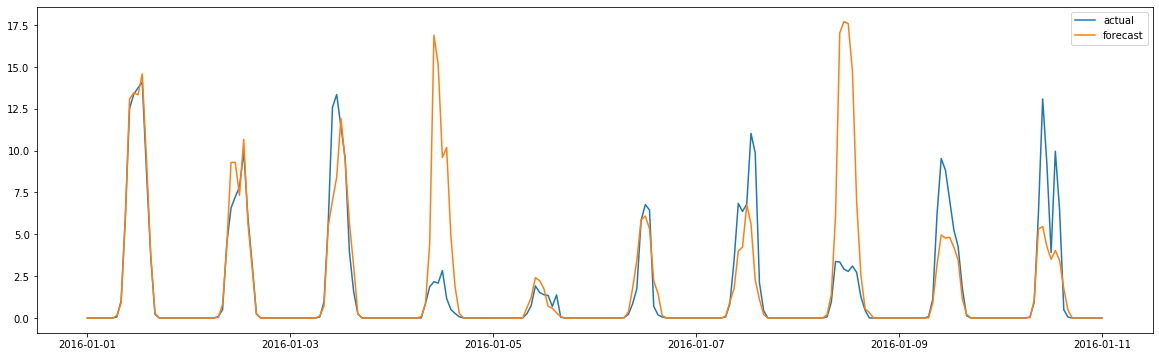

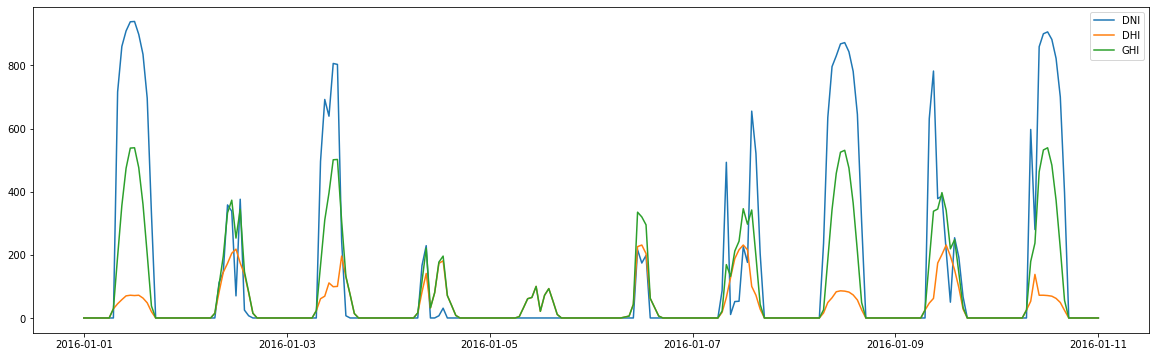

In [164]:
start=dt.datetime(2016,1,1,0,0)
end=start+dt.timedelta(days=10)
plt.figure(figsize=(20,6))
plt.plot(all_data_4['kWh2'][start:end],label='actual')
plt.plot(all_data_4['forecast2'][start:end],label='forecast')
plt.legend();

plt.figure(figsize=(20,6))
plt.plot(all_data_4['DNI'][start:end],label='DNI')
plt.plot(all_data_4['DHI'][start:end],label='DHI')
plt.plot(all_data_4['GHI'][start:end],label='GHI')
plt.legend();

In [274]:
def forecast_winter(startdate,x=7,ndays=30, data_train=data_train):
    train_mse = []
    test_mse = []
    train_rmse = []
    test_rmse = []
    train_mape = []
    test_mape = []
    train_mae = []
    test_mae = []
    data_for_all = []
    data_test1_all = []

    for i in range(0,ndays):
        # generate range
        train_start = startdate+dt.timedelta(hours=24*i)
        train_end = train_start+dt.timedelta(hours=(24*x-1))
        test_start = train_end+dt.timedelta(hours=1)
        test_end = test_start+dt.timedelta(hours=23)

        #subset data
        data_train1 = data_train[train_start:train_end]
        data_test1 = data_train[test_start:test_end]

        weather_train1 = weather[['sunlight']][train_start:train_end]
        weather_test1 = weather[['sunlight']][test_start:test_end]

        solar_train1 = solar[train_start:train_end]
        solar_test1 = solar[test_start:test_end]

    #     print(data_train1.shape)
    #     print(data_test1.shape)
    #     print(weather_train1.values.shape)
    #     print(weather_test1.values.shape)
    #     print(solar_train1.values.shape)
    #     print(solar_test1.values.shape)

        # model, predict, forecast
        sar = sm.tsa.statespace.SARIMAX(data_train1,
                                    exog=solar_train1.values,
                                    order=(6,1,2), 
                                    seasonal_order=(2,1,1,24), 
                                    trend='c').fit(maxiter=250)

        y_pred = sar.predict(start=0,end=len(data_train1)-1,dynamic=False)

        a = data_test1.shape[0]
        data_for = sar.forecast(steps=a, exog=solar_test1.values)

#         print(sar.mle_retvals)

        #remove non-0 data during night hours (can't have negative values, which appear to be momentum)
        for i,val in y_pred.iteritems():
            if weather_train1['sunlight'][i] == 0 :
                y_pred[i]=0
            if val < 0 :
                y_pred[i]=0
        for i,val in data_for.iteritems():
            if weather_test1['sunlight'][i] == 0 :
                data_for[i]=0
            if val < 0 :
                data_for[i]=0

        for j in data_for.values:
            data_for_all.append(j)
        for k in data_test1.values:
            data_test1_all.append(k)
        
#         train_mse.append(mse(data_train1.values,y_pred.values))
#         test_mse.append(mse(data_test1.values,data_for.values))
#         train_rmse.append(np.sqrt(mse(data_train1.values,y_pred.values)))
#         test_rmse.append(np.sqrt(mse(data_test1.values,data_for.values)))

        #calculate MAPE for non-zero values
#         for j,v in data_train1.iteritems():
#             if data_train1[j]==0:
#                 data_train1.pop(j)
#                 y_pred.pop(j)
#         for k,a in data_test1.iteritems():
#             if data_test1[k]==0:
#                 data_test1.pop(k)
#                 data_for.pop(k)

#         train_mape.append(mape(data_train1.values,y_pred.values))
#         test_mape.append(mape(data_test1.values,data_for.values))
        train_mae.append(mae(data_train1.values,y_pred.values))
        test_mae.append(mae(data_test1.values,data_for.values))

    #MAPE for test data
    plt.figure(figsize=(20,6))
    plt.plot(train_mae,alpha=0.5,label='train')
    plt.plot(test_mae,alpha=0.5,label='test')
    plt.title('MAE')
    plt.xlabel('days')
    plt.legend()
    plt.show();

    #RMSE for test data
#     plt.figure(figsize=(20,6))
#     plt.plot(train_rmse,alpha=0.5,label='train')
#     plt.plot(test_rmse,alpha=0.5,label='test')
#     plt.title('RSME')
#     plt.xlabel('days')
#     plt.legend()
#     plt.show();
    
    #test data
    graph_index_a = pd.date_range(startdate,startdate+dt.timedelta(days=ndays+x),freq='H')[:-1]
    graph_index_f = pd.date_range(startdate+dt.timedelta(days=x),startdate+dt.timedelta(days=ndays+x),freq='H')[:-1]
    hist_data = data_train[startdate:startdate+dt.timedelta(days=ndays+x)][:-1]
    solar_data = solar[startdate:startdate+dt.timedelta(days=ndays+x)][:-1]
    weather_data = weather['sunlight'][startdate:startdate+dt.timedelta(days=ndays+x)][:-1]
    
    plt.figure(figsize=(20,6))
    plt.plot(graph_index_a,hist_data,alpha=0.5,label='actual')
    plt.plot(graph_index_f,data_for_all,alpha=0.5,label='forecasted')
    plt.title('forecasted vs. actual')
    plt.xlabel('days')
    plt.legend()
    plt.show();
    
    plt.figure(figsize=(20,6))
    plt.plot(graph_index_a,solar_data['DHI'],alpha=0.5,label='DHI')
    plt.plot(graph_index_a,solar_data['DNI'],alpha=0.5,label='DNI')
    plt.plot(graph_index_a,solar_data['GHI'],alpha=0.5,label='GHI')
    plt.title('solar irradiance')
    plt.xlabel('days')
    plt.legend()
    plt.show();
    
    #save out data
    historical = hist_data.to_frame()
    forecast = pd.DataFrame(data_for_all, index=graph_index_f, columns=['forecast'])
    solar_i = pd.DataFrame(solar_data, index=graph_index_a)
    sunlight = weather_data.to_frame()

    all_data = pd.merge(historical,forecast,left_index=True,right_index=True,how='left')
    all_data = pd.merge(all_data,solar_i,left_index=True,right_index=True)
    all_data = pd.merge(all_data,sunlight,left_index=True,right_index=True)
    
    #save out forecast performance
    forecast_perf = pd.DataFrame(test_mae, index= sorted(list(set(graph_index_f.date))), columns=['MAE'])
    # # log MAPE and rolling average
    # forecast_mape['MAPE2'] = np.log(forecast_mape['MAPE'])
    # forecast_mape['MAPE2_30d'] = forecast_mape['MAPE2'].rolling(30,center=True).mean()
    
    return all_data, forecast_perf

/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.p

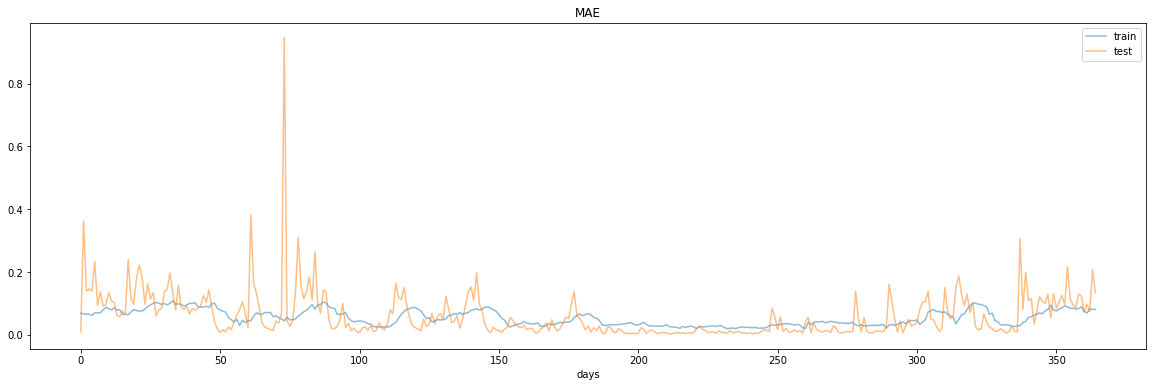

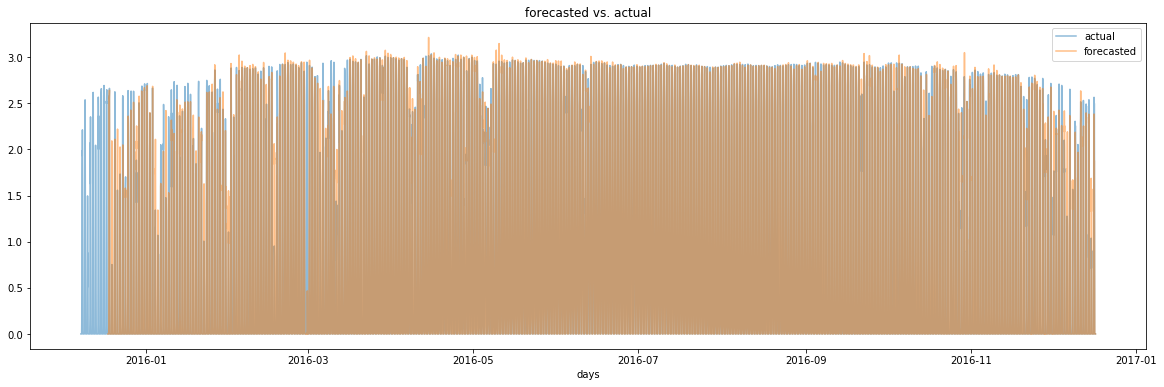

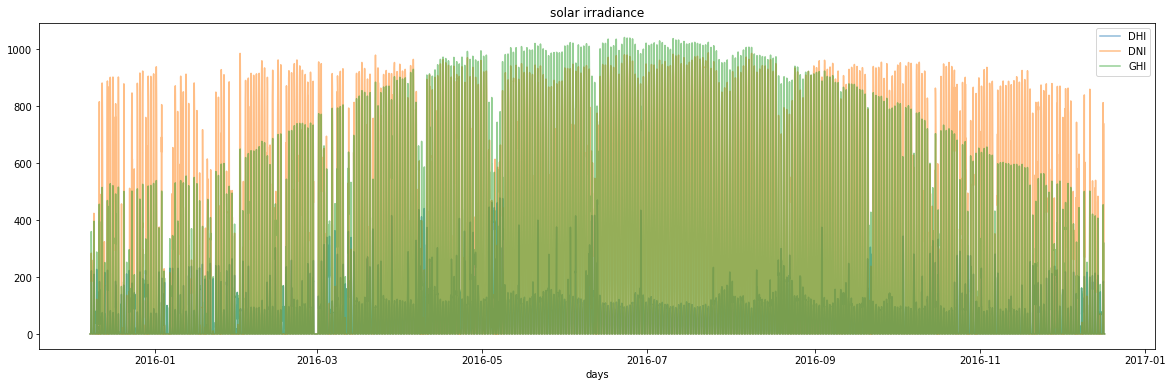

In [275]:
#forecast with logged data, with exog
all_data_5, forecast_perf_5 = forecast_winter(dt.datetime(2015,12,8,0,0),x=10,ndays=365, data_train = data_train_l)


In [276]:
import math

all_data_5['kWh2'] = [math.exp(x)-1 for x in all_data_5['kWh']]
all_data_5['forecast2'] = [math.exp(x)-1 for x in all_data_5['forecast']]

forecast_perf_5['MAE2'] = [math.exp(x)-1 for x in forecast_perf_5['MAE']]

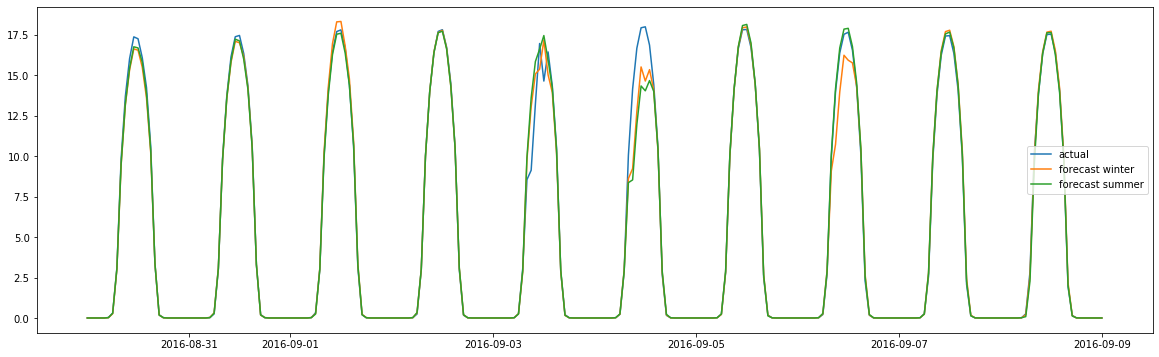

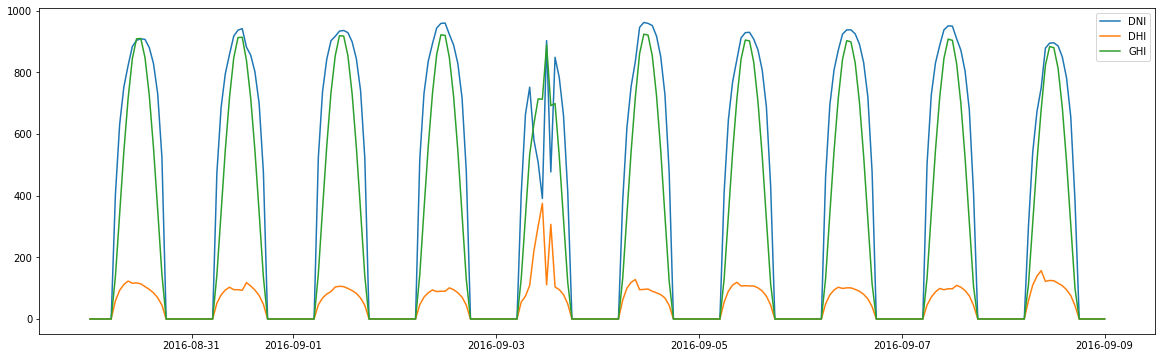

In [296]:
start=dt.datetime(2016,8,30,0,0)
end=start+dt.timedelta(days=10)
plt.figure(figsize=(20,6))
plt.plot(all_data_5['kWh2'][start:end],label='actual')
plt.plot(all_data_5['forecast2'][start:end],label='forecast winter')
plt.plot(all_data_4['forecast2'][start:end],label='forecast summer')
plt.legend();

plt.figure(figsize=(20,6))
plt.plot(all_data_5['DNI'][start:end],label='DNI')
plt.plot(all_data_5['DHI'][start:end],label='DHI')
plt.plot(all_data_5['GHI'][start:end],label='GHI')
plt.legend();

In [278]:
start=dt.datetime(2016,1,1,0,0)
end=start+dt.timedelta(days=90)

all_data_4b = all_data_4[start:end]
all_data_5b = all_data_5[start:end]

In [279]:
all_data_4b['AE'] = abs(all_data_4b['kWh2']-all_data_4b['forecast2'])
all_data_5b['AE'] = abs(all_data_5b['kWh2']-all_data_5b['forecast2'])

/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [280]:
print(np.mean(all_data_4b['AE']))
print(np.mean(all_data_5b['AE']))

0.7256042432141367
0.6702092657604377


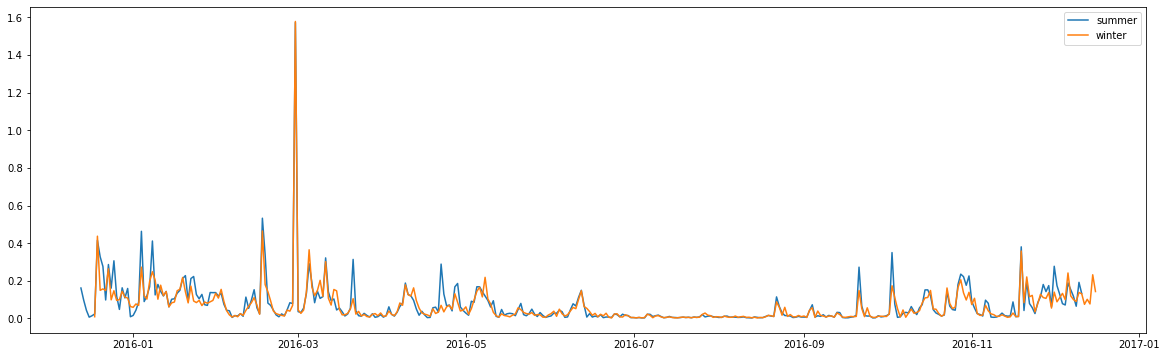

In [282]:
start=dt.date(2016,1,1)
end=start+dt.timedelta(days=90)
plt.figure(figsize=(20,6))

plt.plot(forecast_perf_4['MAE2'],label='summer')
plt.plot(forecast_perf_5['MAE2'],label='winter')
# plt.plot(all_data_4['forecast2'][start:end],label='forecast')
plt.legend();

In [283]:
all_data_5.to_csv('output/all_data2.csv')
forecast_perf_5.to_csv('output/forecast_perf2.csv')